In [520]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [521]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

FRAME_TIME = 0.1  # time interval
Gravitation_acc = 9.80  #constant g = 9.8 m/s^2
BOOST_acc = 15  # assuming thrust constant to be 15 m/s^2 as it ususally more than g 

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action[0] = Thrust in y
        action[1] = Thrust in x
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        """
        #defining gravitaion force in tensor form
        delta_stateG = t.tensor([0., Gravitation_acc * FRAME_TIME, 0., 0.]) #Converting to 2D

        #defining state variables in tensor form
        delta_state_y = BOOST_acc * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0] 
        delta_state_x = BOOST_acc * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]  
        #Updating drag
        Major_reduction = 0.006 * delta_state_y*delta_state_y
        Final = BOOST_ACCEL - Major_reduction # Updating net accel in Y
        #revising new velocity in Y
        delta_state_y = Final * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        # Update velocity
        state = state + delta_state_y + delta_stateG + delta_state_x
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)
        return state


In [522]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),#added new layer
            nn.Linear(dim_hidden, dim_hidden),#added new layer
            nn.Tanh(),#added new layer
            nn.Tanh(),#added a new layer
            nn.Linear(dim_hidden, dim_output),#added new hidden layer
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [523]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        
        state = [5., 0., 2., -1.]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [524]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.007)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        
        plt.subplot(222)
        plt.title('Distance X vs velocity X plot')
        plt.xlabel('DistanceX')
        plt.ylabel('VelocityX')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()
        
        plt.figure()
        plt.subplot(223)
        plt.title('Distance Y vs velocity Y plot')
        plt.xlabel('DistanceY')
        plt.ylabel('VelocityY')
        plt.plot(x, y)
        
        plt.subplot(221)
        plt.title('Distance X vs Distance Y plot')
        plt.xlabel('DistanceX')
        plt.ylabel('DistanceY')
        plt.plot(x, a)
        plt.tight_layout()
        plt.show()
        

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 155021.609


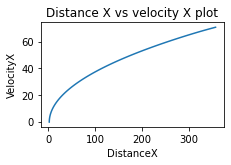

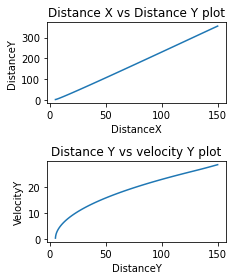

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 145173.172


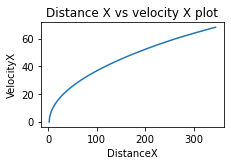

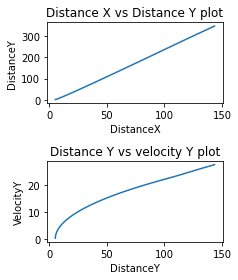

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 117650.102


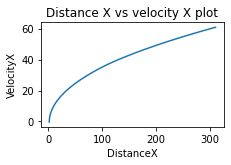

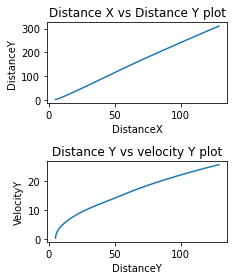

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 70099.281


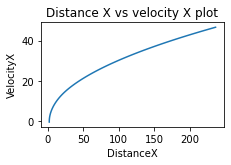

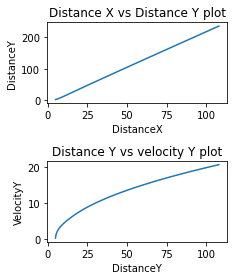

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 39230.996


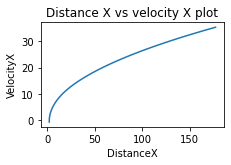

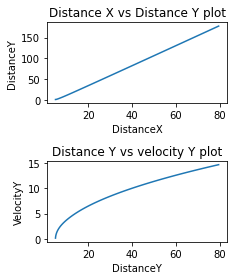

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 25595.826


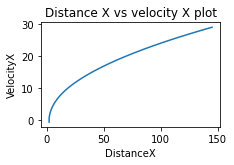

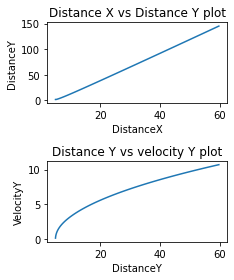

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 17802.744


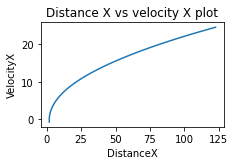

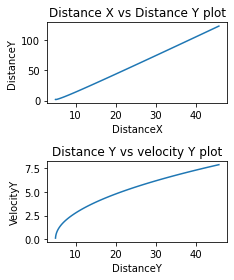

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 12688.832


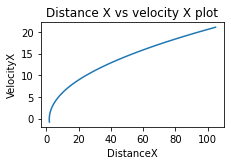

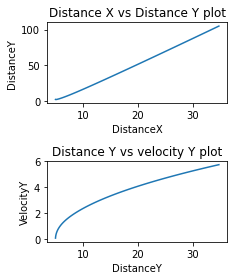

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 8088.069


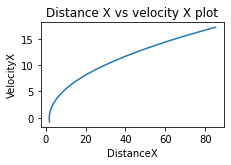

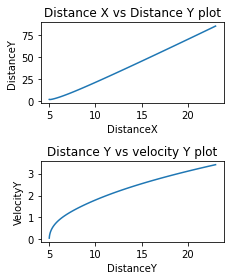

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 5372.278


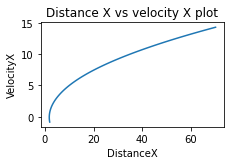

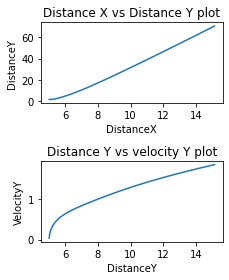

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 3874.475


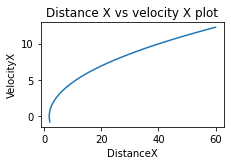

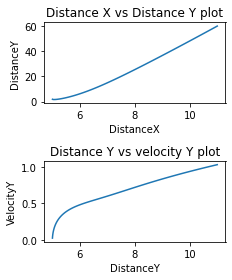

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 2966.130


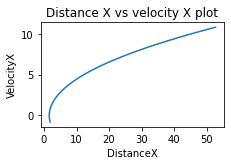

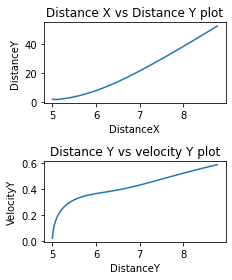

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 2318.111


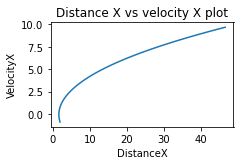

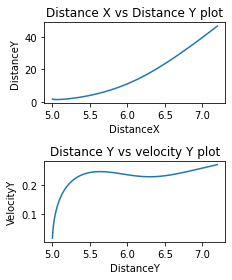

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 1818.574


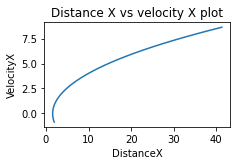

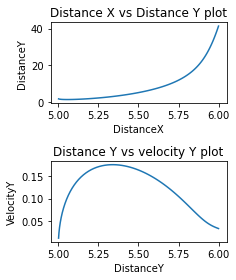

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 1392.280


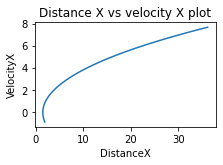

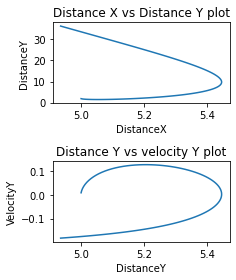

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 905.743


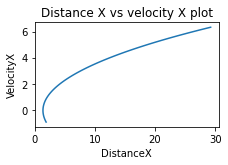

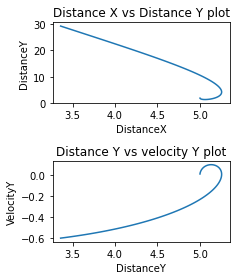

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 577.413


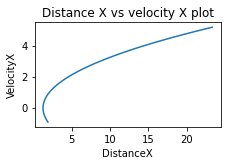

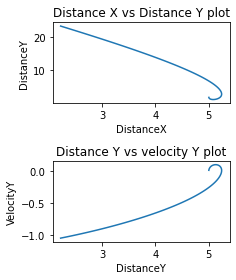

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 402.661


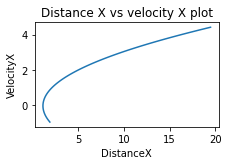

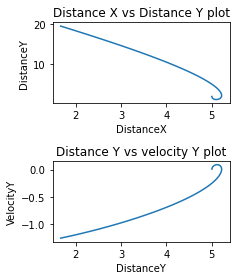

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 290.526


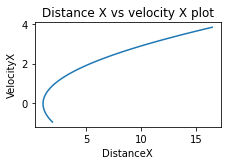

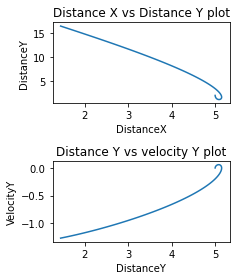

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 209.181


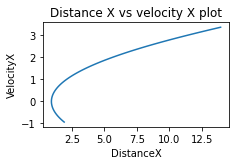

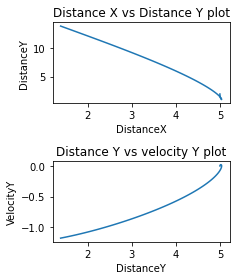

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 147.751


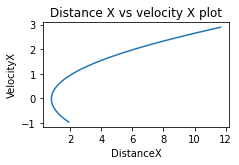

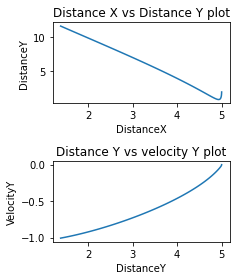

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 104.926


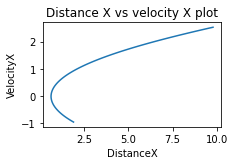

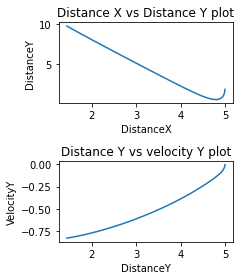

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 74.841


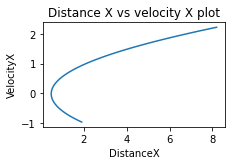

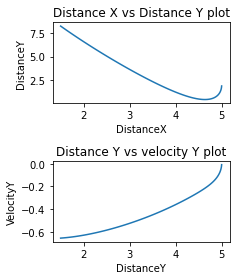

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 56.323


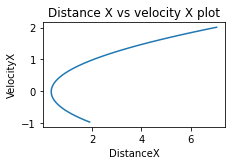

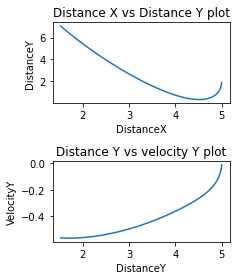

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 43.974


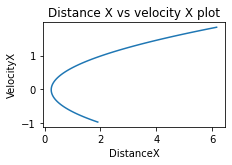

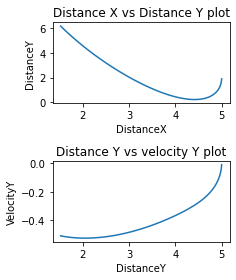

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 34.623


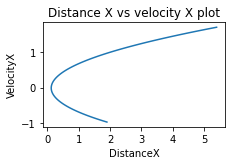

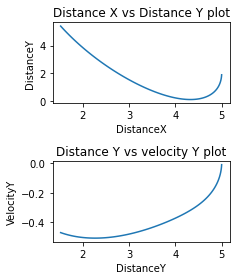

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 26.925


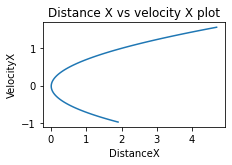

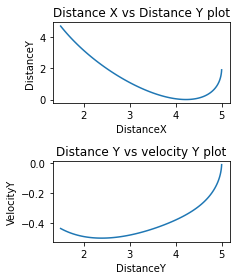

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 20.665


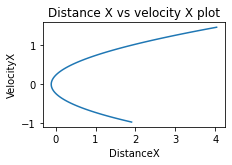

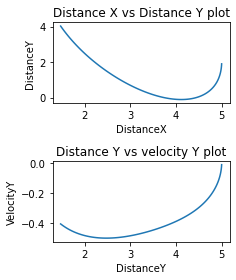

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 16.087


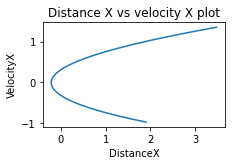

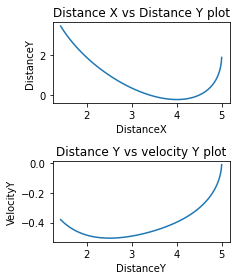

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 12.668


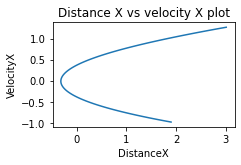

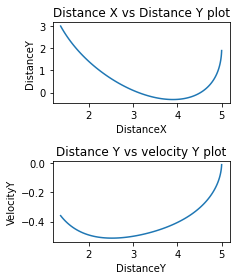

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 10.025


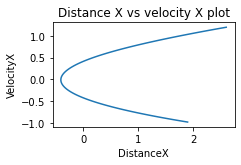

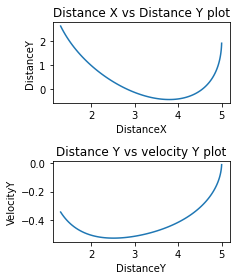

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 7.950


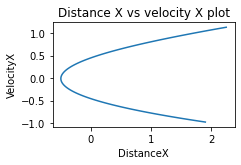

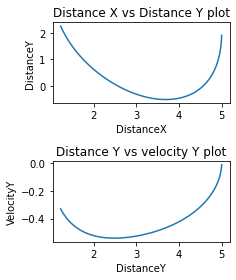

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 6.287


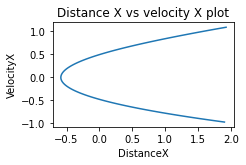

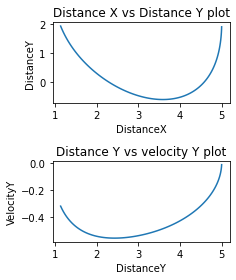

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 4.950


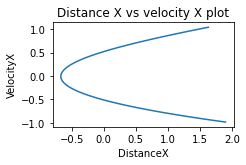

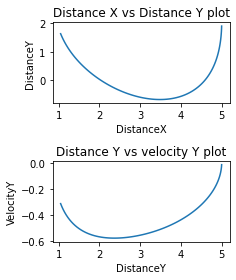

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 3.899


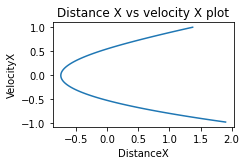

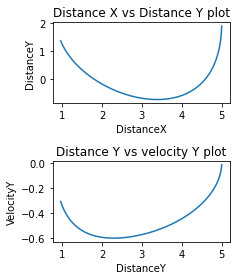

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 3.087


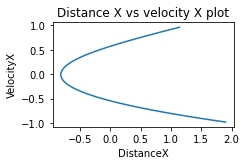

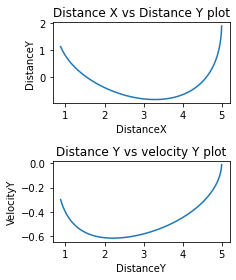

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 2.475


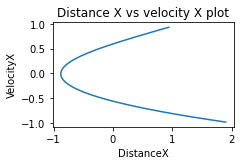

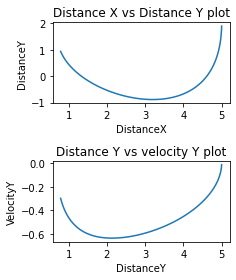

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 2.023


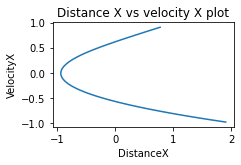

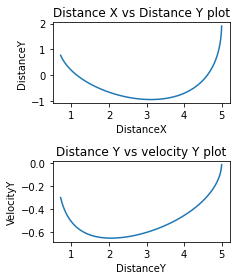

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 1.690


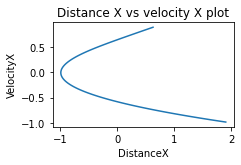

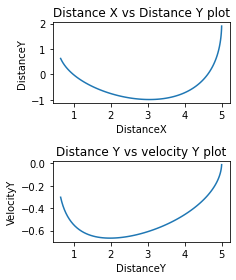

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 1.447


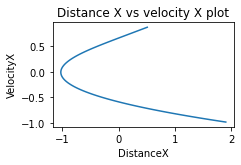

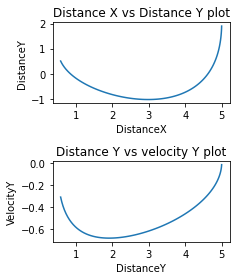

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 1.270


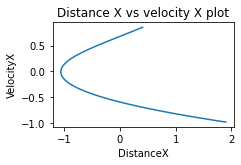

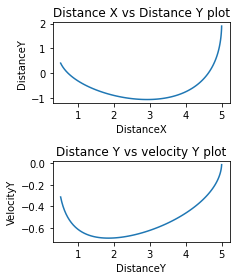

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 1.138


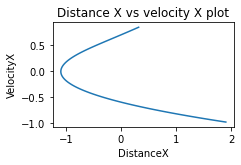

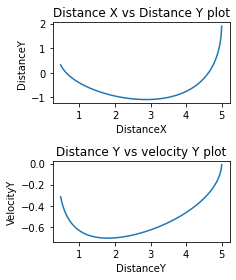

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 1.038


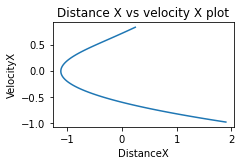

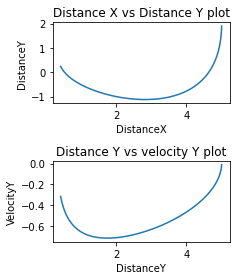

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.956


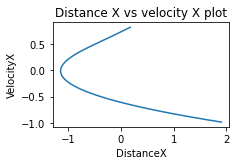

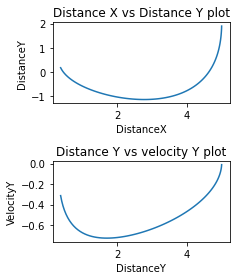

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.887


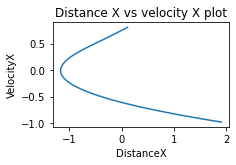

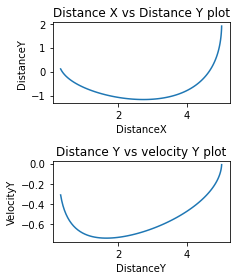

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.832


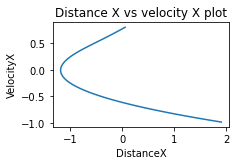

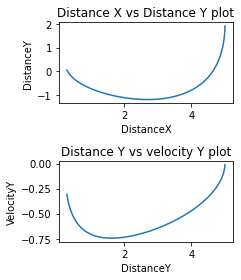

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.784


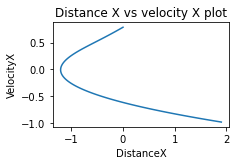

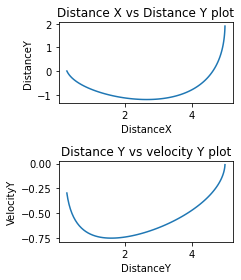

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.739


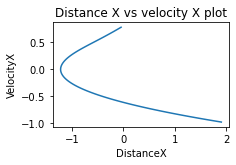

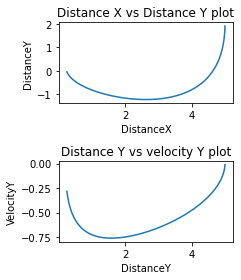

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.698


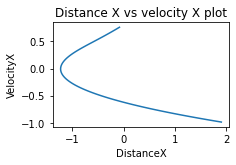

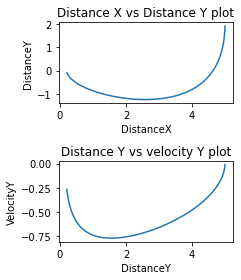

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.658


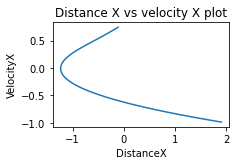

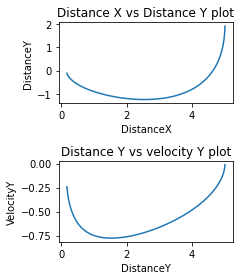

_______________________________________________________________________________________________________________

Iteration number:	 51
loss: 0.603


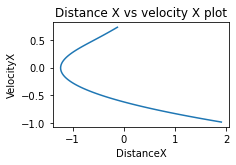

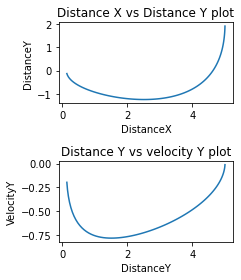

_______________________________________________________________________________________________________________

Iteration number:	 52
loss: 0.538


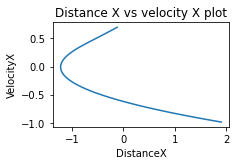

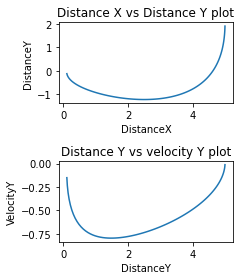

_______________________________________________________________________________________________________________

Iteration number:	 53
loss: 0.485


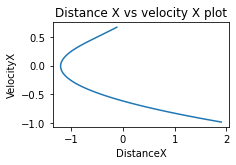

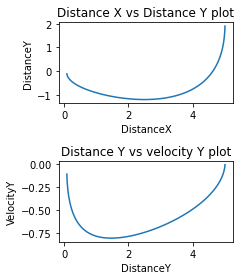

_______________________________________________________________________________________________________________

Iteration number:	 54
loss: 0.444


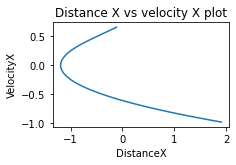

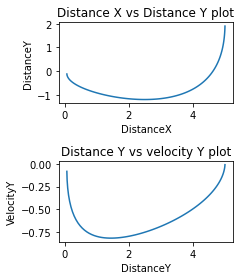

_______________________________________________________________________________________________________________

Iteration number:	 55
loss: 0.411


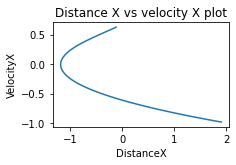

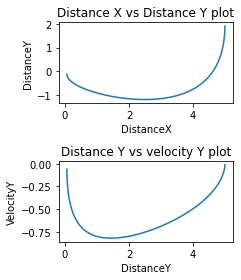

_______________________________________________________________________________________________________________

Iteration number:	 56
loss: 0.380


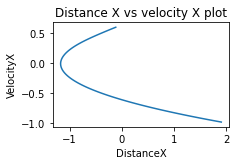

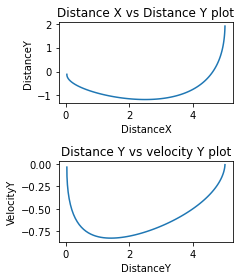

_______________________________________________________________________________________________________________

Iteration number:	 57
loss: 0.348


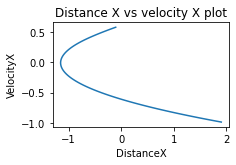

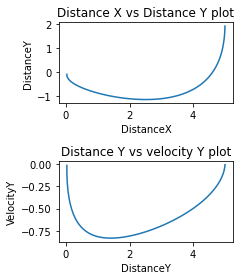

_______________________________________________________________________________________________________________

Iteration number:	 58
loss: 0.307


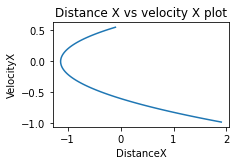

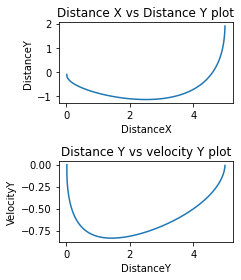

_______________________________________________________________________________________________________________

Iteration number:	 59
loss: 0.262


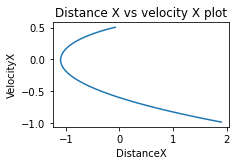

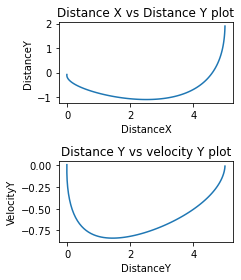

_______________________________________________________________________________________________________________

Iteration number:	 60
loss: 0.226


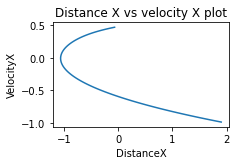

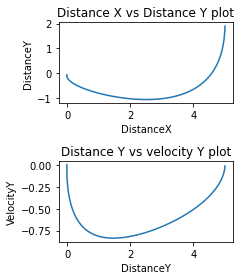

_______________________________________________________________________________________________________________

Iteration number:	 61
loss: 0.203


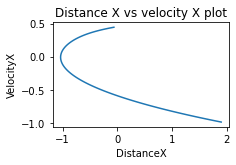

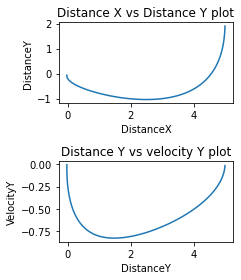

_______________________________________________________________________________________________________________

Iteration number:	 62
loss: 0.183


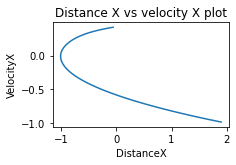

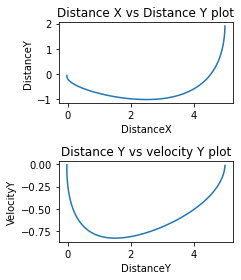

_______________________________________________________________________________________________________________

Iteration number:	 63
loss: 0.165


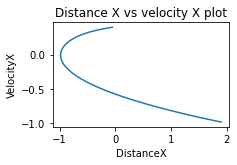

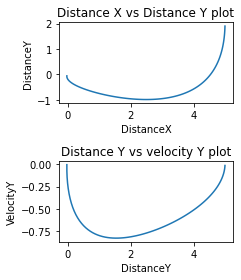

_______________________________________________________________________________________________________________

Iteration number:	 64
loss: 0.147


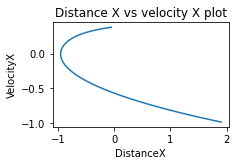

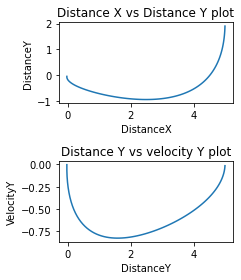

_______________________________________________________________________________________________________________

Iteration number:	 65
loss: 0.129


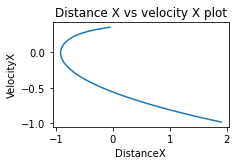

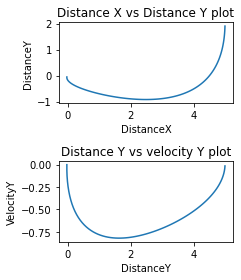

_______________________________________________________________________________________________________________

Iteration number:	 66
loss: 0.112


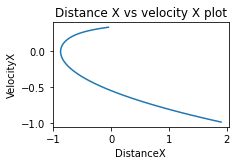

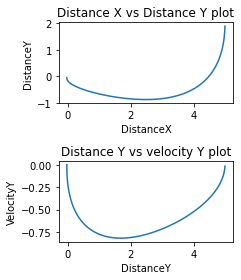

_______________________________________________________________________________________________________________

Iteration number:	 67
loss: 0.095


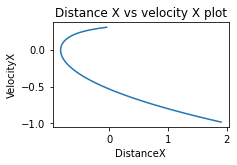

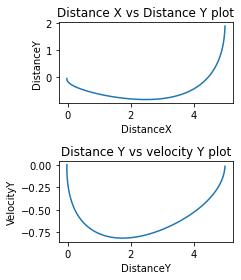

_______________________________________________________________________________________________________________

Iteration number:	 68
loss: 0.080


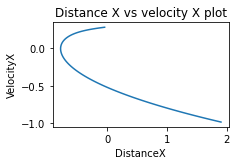

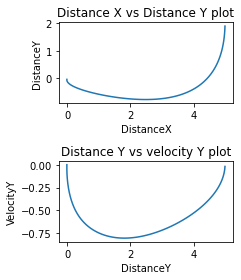

_______________________________________________________________________________________________________________

Iteration number:	 69
loss: 0.067


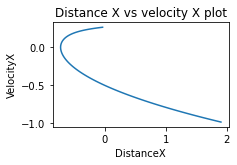

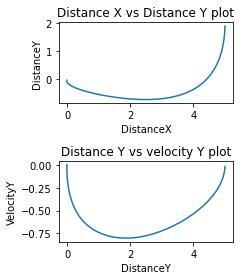

_______________________________________________________________________________________________________________

Iteration number:	 70
loss: 0.056


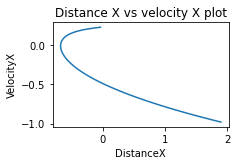

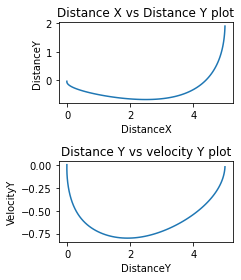

_______________________________________________________________________________________________________________

Iteration number:	 71
loss: 0.046


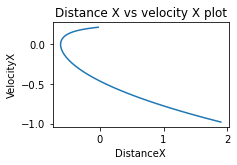

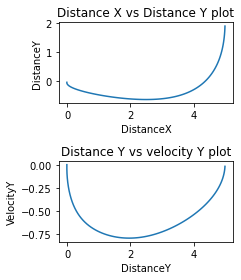

_______________________________________________________________________________________________________________

Iteration number:	 72
loss: 0.038


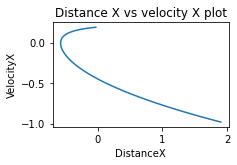

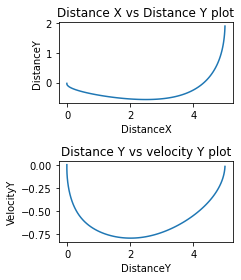

_______________________________________________________________________________________________________________

Iteration number:	 73
loss: 0.031


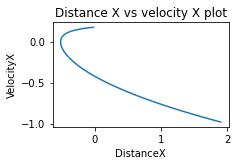

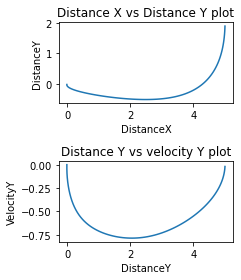

_______________________________________________________________________________________________________________

Iteration number:	 74
loss: 0.025


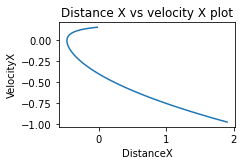

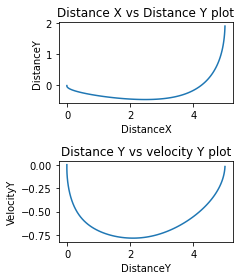

_______________________________________________________________________________________________________________

Iteration number:	 75
loss: 0.021


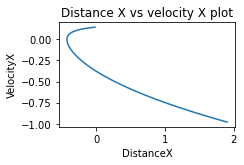

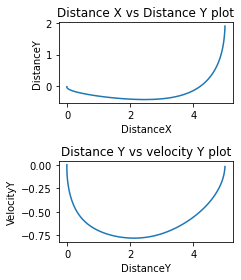

_______________________________________________________________________________________________________________

Iteration number:	 76
loss: 0.017


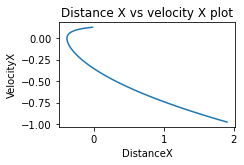

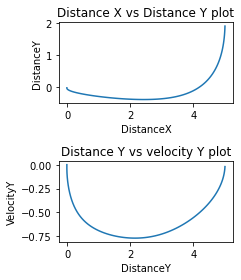

_______________________________________________________________________________________________________________

Iteration number:	 77
loss: 0.013


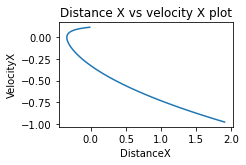

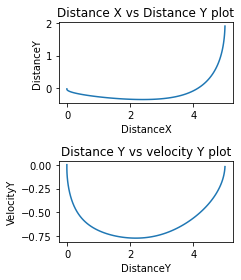

_______________________________________________________________________________________________________________

Iteration number:	 78
loss: 0.011


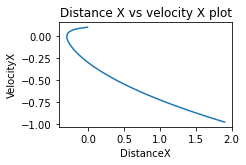

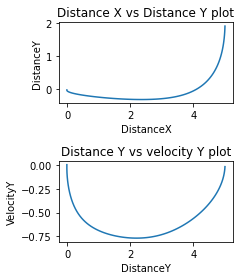

_______________________________________________________________________________________________________________

Iteration number:	 79
loss: 0.009


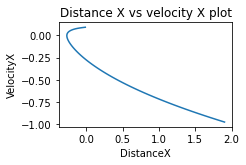

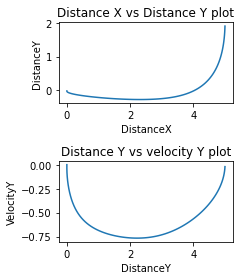

_______________________________________________________________________________________________________________

Iteration number:	 80
loss: 0.007


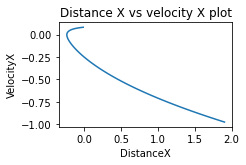

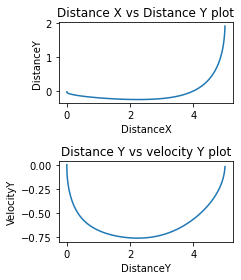

_______________________________________________________________________________________________________________

Iteration number:	 81
loss: 0.005


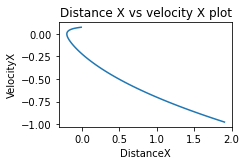

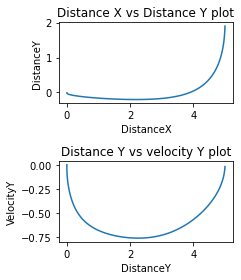

_______________________________________________________________________________________________________________

Iteration number:	 82
loss: 0.004


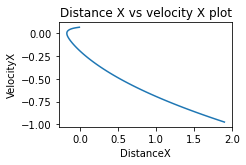

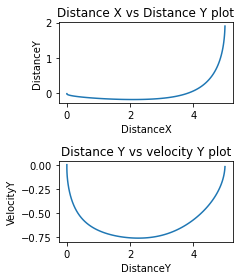

_______________________________________________________________________________________________________________

Iteration number:	 83
loss: 0.003


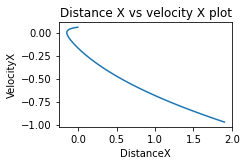

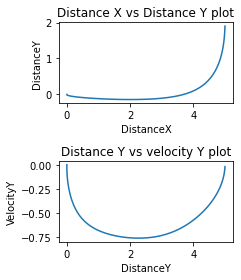

_______________________________________________________________________________________________________________

Iteration number:	 84
loss: 0.003


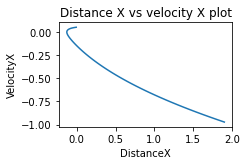

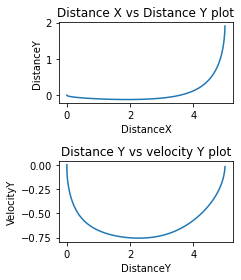

_______________________________________________________________________________________________________________

Iteration number:	 85
loss: 0.002


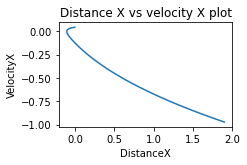

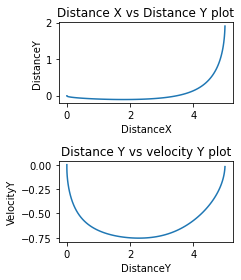

_______________________________________________________________________________________________________________

Iteration number:	 86
loss: 0.002


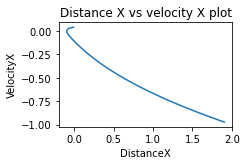

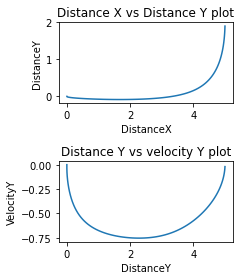

_______________________________________________________________________________________________________________

Iteration number:	 87
loss: 0.001


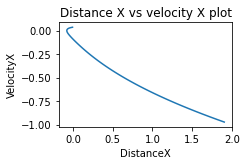

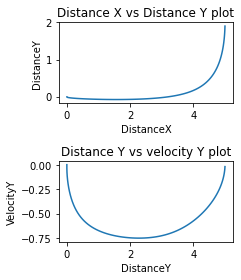

_______________________________________________________________________________________________________________

Iteration number:	 88
loss: 0.001


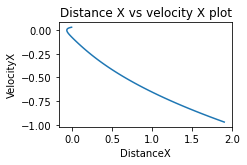

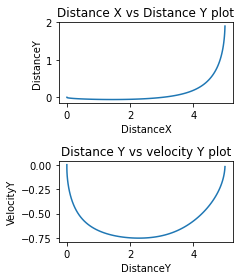

_______________________________________________________________________________________________________________

Iteration number:	 89
loss: 0.001


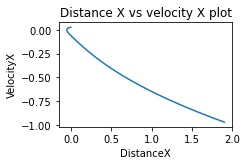

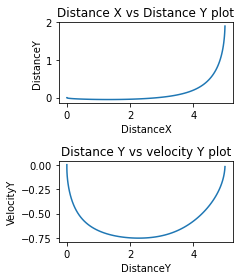

_______________________________________________________________________________________________________________

Iteration number:	 90
loss: 0.001


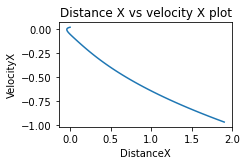

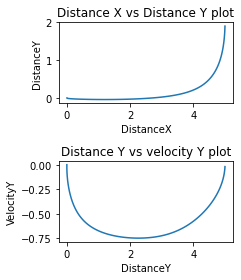

_______________________________________________________________________________________________________________

Iteration number:	 91
loss: 0.000


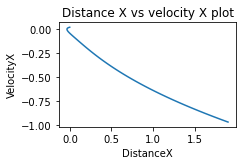

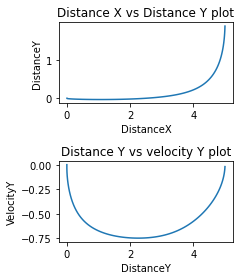

_______________________________________________________________________________________________________________

Iteration number:	 92
loss: 0.000


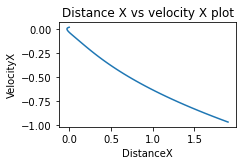

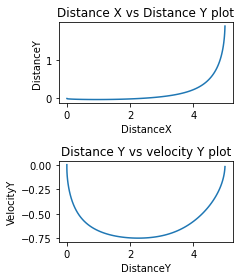

_______________________________________________________________________________________________________________

Iteration number:	 93
loss: 0.000


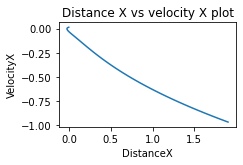

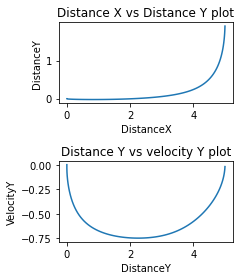

_______________________________________________________________________________________________________________

Iteration number:	 94
loss: 0.000


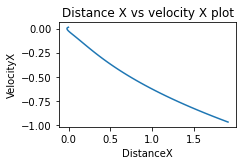

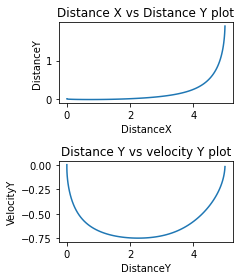

_______________________________________________________________________________________________________________

Iteration number:	 95
loss: 0.000


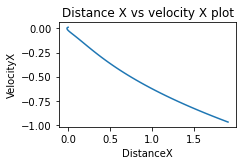

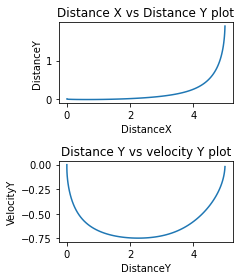

_______________________________________________________________________________________________________________

Iteration number:	 96
loss: 0.000


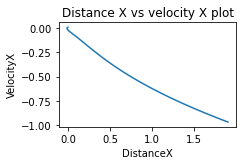

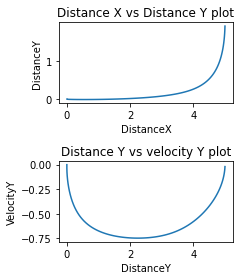

_______________________________________________________________________________________________________________

Iteration number:	 97
loss: 0.000


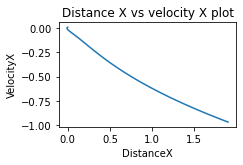

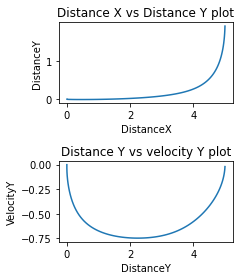

_______________________________________________________________________________________________________________

Iteration number:	 98
loss: 0.000


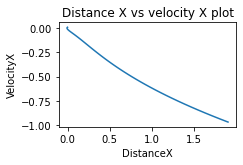

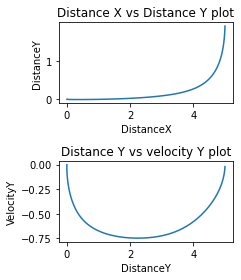

_______________________________________________________________________________________________________________

Iteration number:	 99
loss: 0.000


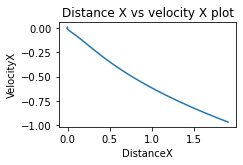

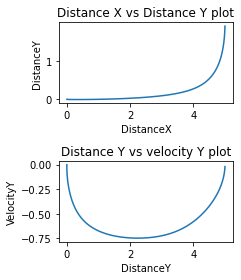

_______________________________________________________________________________________________________________

Iteration number:	 100
loss: 0.000


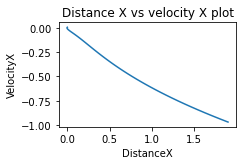

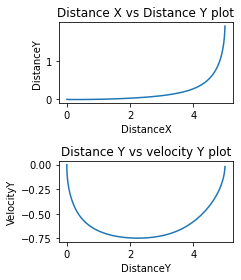

In [525]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (a_y, a_x)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)  # solve the optimization problem